# Criteria selection | baseline model experiment #3

## Table of contents:

* [Test accuracy]()
* [Confusion matrix]()
* [tSNE plot]
* [Generalization error]
* [Model certainty]
* [Rejection cost]
* [Calibration error]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yaml
import pickle

In [2]:
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('..')))

In [3]:
import torch
import torchvision

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

from stochastic_predictors.modules.model.cnn import StochasticCNN

%reload_ext autoreload
%autoreload 2

In [4]:
os.chdir('../modules')

## Baseline model experiments #3 | tests <a class="anchor" id="exp-03-t"></a>

In [5]:
CLASSES = [
    "T-shirt/top", "Trousers", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [10]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", dev)

# load experiment configuration file
with open("../experiments/exp-b04/config-b04.yaml") as config:
    params = dict(yaml.load(config, Loader=yaml.FullLoader))

# load model
net = StochasticCNN(params["model"], params["n_for_features"], params["batch_norm"])
net.load_state_dict(torch.load("../experiments/exp-b06/baseline-adversarial-checkpoint3.pt"))
# net = net.to(dev)

Using device: cuda


100%|██████████| 18/18 [00:00<00:00, 3783.39it/s]


<All keys matched successfully>

In [11]:
# load data
params["normalize_params"] = list(map(float, params["normalize_params"].strip().split(",")))
params["normalize_params"] = {
    "mean": params["normalize_params"][0],
    "std": params["normalize_params"][1]
}
t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(**params["normalize_params"])
])

test_set = FashionMNIST('../data', download=True, train=False, transform=t)
test_loader = DataLoader(test_set, batch_size=len(test_set))

In [13]:
softmax = torch.nn.Softmax(dim=1)

# for (data, target) in test_loader:
#     data = data.to(dev)
#     y = softmax(net.forward(data))
    
#     preds = torch.argmax(y, dim=1).cpu()

In [11]:
assert preds.size() == target.size(), "! unmatched sizes of target and model prediction"

### Test accuracy

In [12]:
acc = float((target == preds).sum() / target.size(0))
print(f"Test accuracy = ", acc)

Test accuracy =  0.824400007724762


### Confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
cm = confusion_matrix(target, preds)

<Figure size 640x480 with 0 Axes>

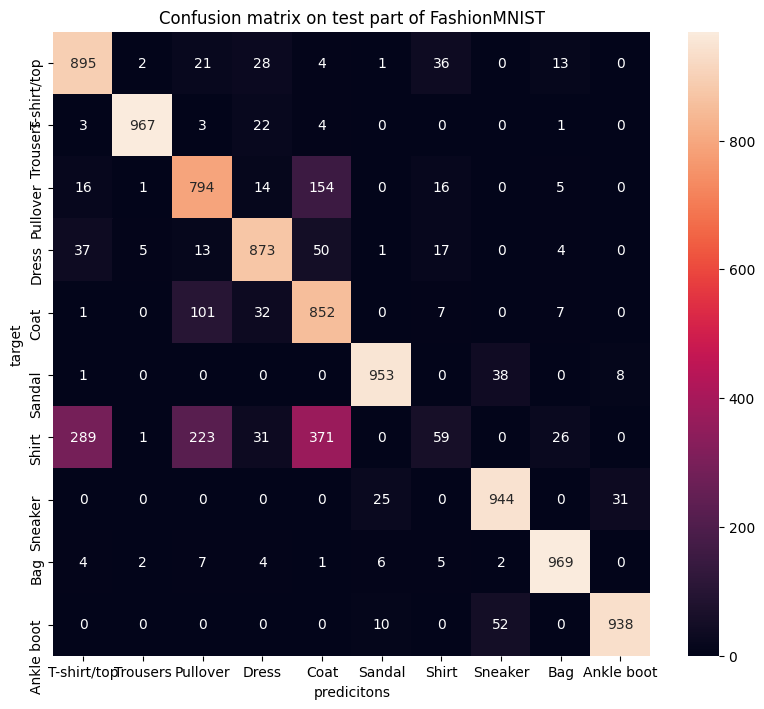

In [15]:
plt.clf()
plt.figure(figsize=(8, 7))

ax = sns.heatmap(cm, annot=True, fmt="g")

ax.set_title("Confusion matrix on test part of FashionMNIST")
ax.figure.tight_layout()
ax.set_xlabel("predicitons")
ax.set_ylabel("target")
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)

plt.show()

### tSNE plot of features extracted by model

In [14]:
from sklearn.manifold import TSNE

In [15]:
test_loader = DataLoader(test_set, batch_size=5000)

for i, (data, t_target) in enumerate(test_loader):
    data = data
    features = net.features(data)
    
features = features.cpu().detach().numpy()

tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

<Figure size 640x480 with 0 Axes>

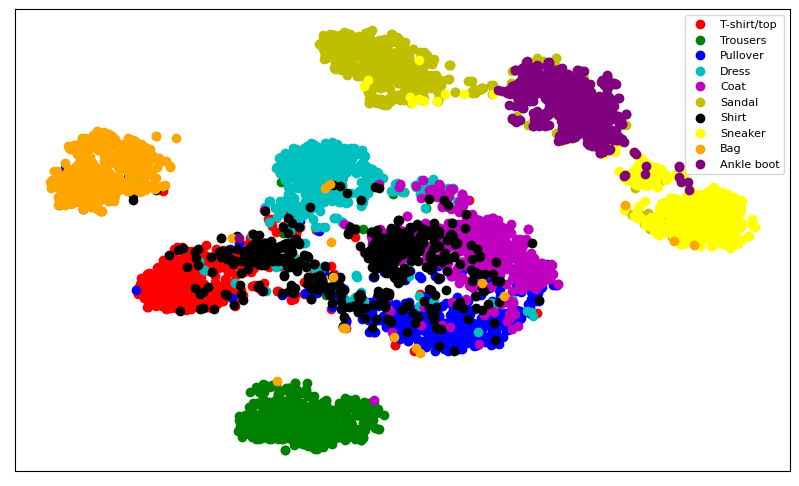

In [17]:
plt.clf()

plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'yellow', 'orange', 'purple']

for i in range(10):
    idx = np.where(t_target == i)[0]
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], color=colors[i], label=CLASSES[i])

# plt.xlabel("x [units]")
# plt.ylabel("y [units]")
# plt.title("tSNE plot of features extracted by model")
plt.xticks([])
plt.yticks([])
plt.legend(prop={'size': 8})
# plt.legend()

plt.show()

### Bounds on the generalization error

### Bayes-Stability [1]

Data based upper bound on model generalization error.

$$min(2C\mathbb{E}_x\sqrt{\mathcal{D}_{KL}(P || Q_z)}), 2C\mathbb{E}_x\sqrt{\mathcal{D}_{KL}(Q_z || P)}))$$

where $C$ is the upper bound on the loss function values.

### Generaliation error

**?** i.e. the gap between the 0\1 loss on train set and data set. [1]

### Model certainty

In [26]:
y = y.cpu().detach().numpy()

<Figure size 640x480 with 0 Axes>

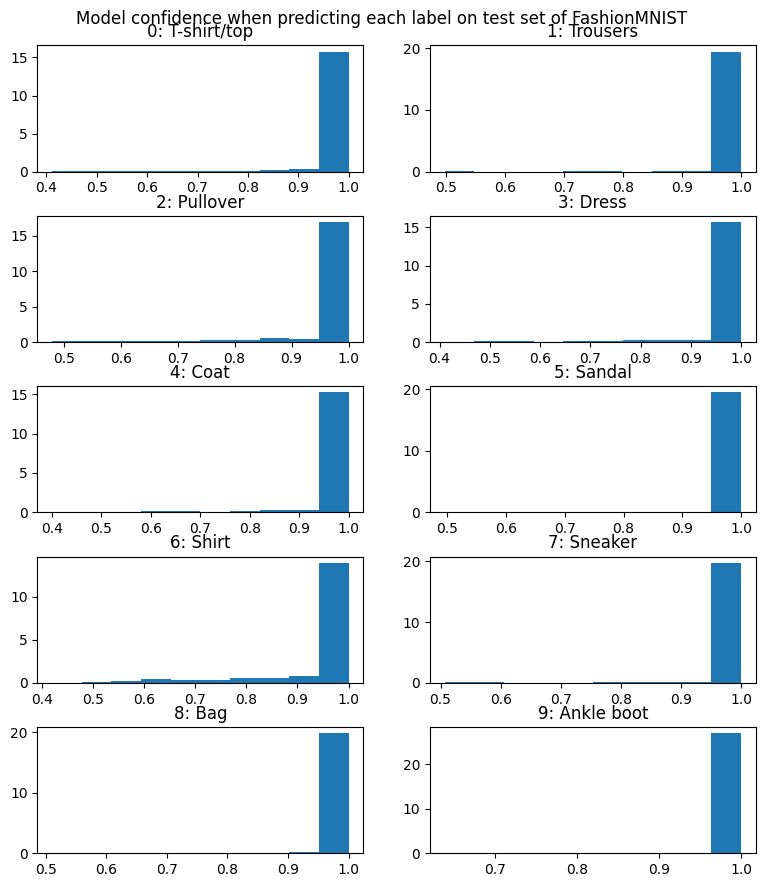

In [27]:
plt.clf()

fig, axs = plt.subplots(5, 2, figsize=(8, 9))
fig.suptitle("Model confidence when predicting each label on test set of FashionMNIST")
fig.tight_layout()

for l in range(10):
    axs.flat[l].hist(y[preds == l, l], bins=10, density=True)
    axs.flat[l].set_title(f"{l}: {CLASSES[l]}", )

plt.show()

### Rejection cost

### Calibration curves

In [28]:
from sklearn.calibration import calibration_curve

<Figure size 640x480 with 0 Axes>

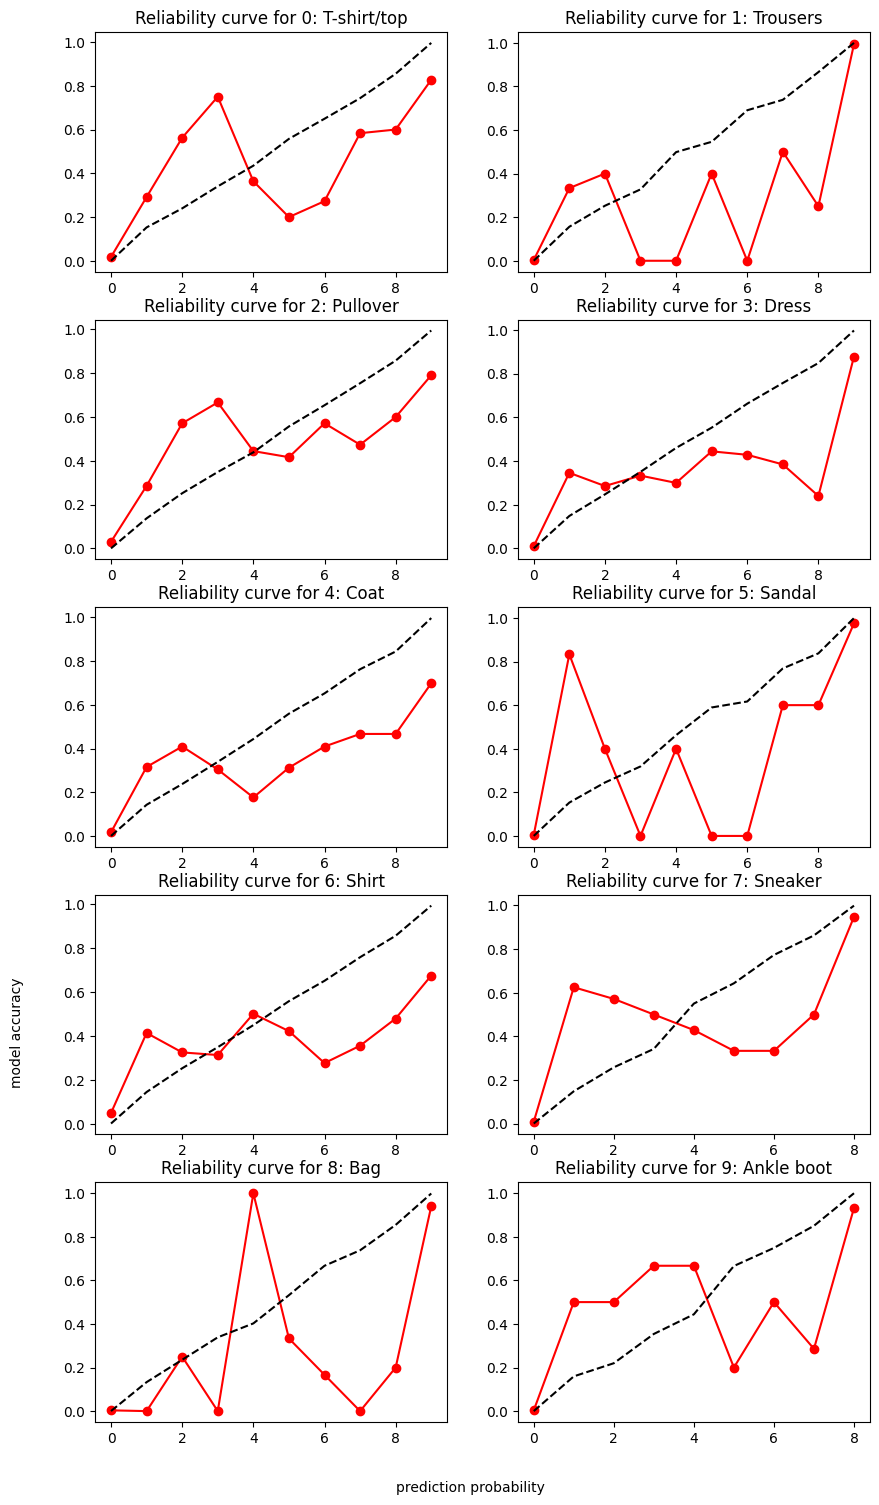

In [29]:
plt.clf()

fig, axs = plt.subplots(5, 2, figsize=(10, 10))

for l in range(10):
    l_target = np.zeros(target.size(0))
    l_target[target == l] = 1
    l_p = y[:, l]
    prob_true, prob_pred = calibration_curve(l_target, l_p, n_bins=10)
    
    axs.flat[l].plot(prob_true, 'ro-')
    axs.flat[l].plot(prob_pred, 'k--',)
    axs.flat[l].set_title(f"Reliability curve for {l}: {CLASSES[l]}")

fig.text(0.5, 0.04, "prediction probability", ha='center')
fig.text(0.04, 0.5, "model accuracy", va='center', rotation='vertical')
plt.subplots_adjust(top=1.5)    
plt.show()

### Robustness against missing features

In [30]:
n = len(test_set)
test_loader = DataLoader(test_set, batch_size=n)

for (data, target) in test_loader:
    data[:, :,  :14] = torch.zeros((n, 1, 14, 28))
    data = data.to(dev)
    
    y = softmax(net.forward(data))
    preds = torch.argmax(y, dim=1).cpu()
    
acc = float((target == preds).sum() / target.size(0))
print(f"Accuracy on the left half of image =", acc)

Accuracy on the left half of image = 0.4478999972343445


In [31]:
for (data, target) in test_loader:
    data[:, :,  14:] = torch.zeros((n, 1, 14, 28))
    data = data.to(dev)
    
    y = softmax(net.forward(data))
    preds = torch.argmax(y, dim=1).cpu()
    
acc = float((target == preds).sum() / target.size(0))
print(f"Accuracy on the right half of image =", acc)

Accuracy on the right half of image = 0.6492999792098999


In [32]:
for (data, target) in test_loader:
    data[:, :,  :, :14] = torch.zeros((n, 1, 28, 14))
    data = data.to(dev)
    
    y = softmax(net.forward(data))
    preds = torch.argmax(y, dim=1).cpu()
    
acc = float((target == preds).sum() / target.size(0))
print(f"Accuracy on the upper half of image =", acc)

Accuracy on the upper half of image = 0.5238999724388123


In [33]:
for (data, target) in test_loader:
    data[:, :,  :, 14:] = torch.zeros((n, 1, 28, 14))
    data = data.to(dev)
    
    y = softmax(net.forward(data))
    preds = torch.argmax(y, dim=1).cpu()
    
acc = float((target == preds).sum() / target.size(0))
print(f"Accuracy on the lower half of image =", acc)

Accuracy on the lower half of image = 0.5195000171661377


In [34]:
for (data, target) in test_loader:
    noise = torch.randn(n, 1, 28, 28)
    noise[noise < 0] = 0
    noise[noise > 0] = 1
    data *= noise
    data = data.to(dev)
    
    y = softmax(net.forward(data))
    preds = torch.argmax(y, dim=1).cpu()
    
acc = float((target == preds).sum() / target.size(0))
print(f"Accuracy on original data with multiplicative noise =", acc)
print(f"Ratio of missing features =", 1 - float(noise.mean()))

Accuracy on original data with multiplicative noise = 0.47839999198913574
Ratio of missing features = 0.5000437498092651


### Robustness against adversarial attacks

In [37]:
s_idx = (target == 6).nonzero()  # shirt 
c_idx = (target == 4).nonzero()  # coat

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

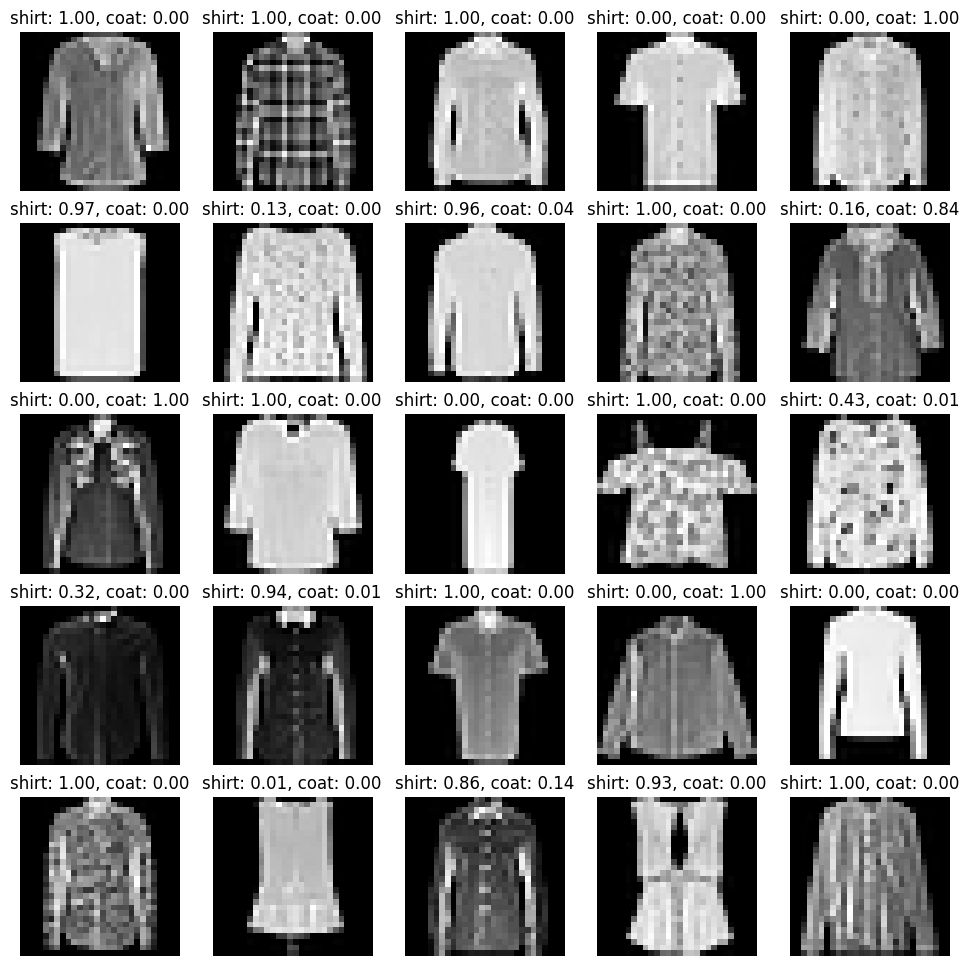

In [69]:
N = 25

plt.clf()

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
# fig.tight_layout()

net.eval()
for i in range(N):
    batch = torch.unsqueeze(test_set[s_idx[i, 0]][0], 0).to(dev)
    ps = torch.squeeze(softmax(net.forward(batch)), 0)
    
    axs.flat[i].imshow(test_set[s_idx[i, 0]][0][0], cmap="gray")
    axs.flat[i].set_axis_off()
    axs.flat[i].set_title(f"shirt: {ps[6]:.2f}, coat: {ps[4]:.2f}")
    
plt.show()

In [65]:
target_class = 4  # coat
EPOCHS = 100
EPS = 3.4

inp_batch = torch.unsqueeze(test_set[0][0], 0).to(dev)
x = inp_batch.clone()
x.requires_grad = True

optimizer = torch.optim.Adam(params=[x], lr=0.01)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    ps = softmax(net.forward(x))
    obj = -ps[0, target_class]
    obj.backward()
    optimizer.step()
    
    dx = x.detach() - inp_batch
    dn = dx.flatten().norm()
    div = torch.clamp(dn / EPS, min=1.0)
    dx = dx / div
    x.data = inp_batch + dx
    
    print(f"Epoch {epoch + 1}/{EPOCHS} - target class probability = {ps[0, target_class]}")

Epoch 1/100 - target class probability = 1.213296352275961e-09
Epoch 2/100 - target class probability = 1.2808389904250816e-09
Epoch 3/100 - target class probability = 1.3549376065569163e-09
Epoch 4/100 - target class probability = 1.4366348111138905e-09
Epoch 5/100 - target class probability = 1.5272376696628953e-09
Epoch 6/100 - target class probability = 1.6283149273377262e-09
Epoch 7/100 - target class probability = 1.7418364528509755e-09
Epoch 8/100 - target class probability = 1.870254395797133e-09
Epoch 9/100 - target class probability = 2.0166266434529234e-09
Epoch 10/100 - target class probability = 2.1848312048433627e-09
Epoch 11/100 - target class probability = 2.3798771842109545e-09
Epoch 12/100 - target class probability = 2.6081361514940227e-09
Epoch 13/100 - target class probability = 2.8779214567009603e-09
Epoch 14/100 - target class probability = 3.2000380123520245e-09
Epoch 15/100 - target class probability = 3.5887153249092307e-09
Epoch 16/100 - target class probabil

In [74]:
plt.clf()

plt.imshow(torch.squeeze(x.cpu().data, 0))
plt.show()

RuntimeError: CUDA error: unspecified launch failure

In [67]:
inp_batch = torch.unsqueeze(test_set[22][0], 0).to(dev)
x = inp_batch.clone()
x.requires_grad = True

optimizer = torch.optim.Adam(params=[x], lr=0.01)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    ps = softmax(net.forward(x))
    obj = -ps[0, target_class]
    obj.backward()
    optimizer.step()
    
    dx = x.detach() - inp_batch
    dn = dx.flatten().norm()
    div = torch.clamp(dn / EPS, min=1.0)
    dx = dx / div
    x.data = inp_batch + dx
    
    print(f"Epoch {epoch + 1}/{EPOCHS} - target class probability = {ps[0, target_class]}")

Epoch 1/100 - target class probability = 6.238912858558265e-11
Epoch 2/100 - target class probability = 6.250359257942151e-11
Epoch 3/100 - target class probability = 6.261813983998721e-11
Epoch 4/100 - target class probability = 6.273265934497729e-11
Epoch 5/100 - target class probability = 6.28481156006444e-11
Epoch 6/100 - target class probability = 6.296330123944927e-11
Epoch 7/100 - target class probability = 6.307917382875061e-11
Epoch 8/100 - target class probability = 6.319526152376298e-11
Epoch 9/100 - target class probability = 6.331181412466691e-11
Epoch 10/100 - target class probability = 6.342808916981468e-11
Epoch 11/100 - target class probability = 6.354494014315648e-11
Epoch 12/100 - target class probability = 6.366249194478257e-11
Epoch 13/100 - target class probability = 6.378039069110386e-11
Epoch 14/100 - target class probability = 6.389825474295563e-11
Epoch 15/100 - target class probability = 6.40168335008795e-11
Epoch 16/100 - target class probability = 6.4135627